In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Fruit_States_RnC'

/content/drive/.shortcut-targets-by-id/1bNsY41NQ7yt_0gKqP3j-2gJ1pdli4usp/Fruit_States_RnC


In [3]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

X = np.load("data8/X_full8.npy")
print(X.shape)

y = np.load("data8/y_avsb_full8.npy")
print(y.shape)

# num_images = len(y)
# indices = np.arange(num_images)
# np.random.seed(1)
# np.random.shuffle(indices)

# train_end = int(0.7 * num_images)
# val_end = int(0.9 * num_images)

# train_indices = indices[:train_end]
# val_indices = indices[train_end:val_end]
# test_indices = indices[val_end:]

# X_train, y_train = X[train_indices], y[train_indices]
# X_val, y_val = X[val_indices], y[val_indices]
# X_test, y_test = X[test_indices], y[test_indices]

# np.save('data_fruits/X_train.npy', X_train)
# np.save('data_fruits/y_train.npy', y_train)
# np.save('data_fruits/X_val.npy', X_val)
# np.save('data_fruits/y_val.npy', y_val)
# np.save('data_fruits/X_test.npy', X_test)
# np.save('data_fruits/y_test.npy', y_test)

# print("Training set shape:", X_train.shape, y_train.shape)
# print("Validation set shape:", X_val.shape, y_val.shape)
# print("Test set shape:", X_test.shape, y_test.shape)

(1624, 50, 50, 8)
(1624,)


In [17]:
import argparse
import os
import sys
import logging
import torch
import time
import numpy as np
from model_fruits import Encoder, model_dict
from dataset_fruits import *
from utils_fruits import *

def parse_option(args=None):
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=10, help='print frequency')
    parser.add_argument('--save_freq', type=int, default=50, help='save frequency')

    parser.add_argument('--batch_size', type=int, default=64, help='batch_size')
    parser.add_argument('--num_workers', type=int, default=16, help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=100, help='number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=0.05, help='learning rate')
    parser.add_argument('--lr_decay_rate', type=float, default=0.2, help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=0, help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
    parser.add_argument('--trial', type=str, default='0', help='id for recording multiple runs')

    parser.add_argument('--data_folder', type=str, default='./data_fruits', help='path to custom dataset')
    parser.add_argument('--dataset', type=str, default='FruitsDataset', choices=['FruitsDataset', 'FruitsDatasetV2', 'FruitsDatasetRGB'], help='dataset')
    parser.add_argument('--model', type=str, default='resnet18', choices=['resnet18', 'resnet50'])
    parser.add_argument('--resume', type=str, default='', help='resume ckpt path')
    parser.add_argument('--aug', type=str, default='crop,flip,color,grayscale,rotate', help='augmentations')

    parser.add_argument('--ckpt', type=str, default='', help='path to the trained encoder')

    if args is None:
        args = []
    opt = parser.parse_args(args=args)

    return opt

def set_loader(opt, split='', num_channel=8):
    transforms = get_transforms(split='val', aug=opt.aug, num_channel=num_channel)

    dataset = globals()[opt.dataset](
        data_folder=opt.data_folder,
        transform=transforms,
        split=split
    )

    print(f'Set size: {dataset.__len__()}\t')

    loader = torch.utils.data.DataLoader(
        dataset, batch_size=opt.batch_size, shuffle=False, num_workers=opt.num_workers, pin_memory=True
    )

    return loader

# def predict(loader, model, regressor, split=''):
#   model.eval()
#   regressor.eval()

#   # losses = AverageMeter()
#   # criterion_l1 = torch.nn.L1Loss()
#   all_outputs = []

#   with torch.no_grad():
#       for idx, (images, labels) in enumerate(loader):
#           images = images.cuda()
#           labels = labels.cuda()
#           bsz = labels.shape[0]

#           features = model(images)
#           output = regressor(features)

#           all_outputs.append(output.detach().cpu().numpy())

#           # loss_l1 = criterion_l1(output, labels)
#           # losses.update(loss_l1.item(), bsz)

#   all_outputs = np.concatenate(all_outputs, axis=0)
#   # np.save('outputs/predicted_y_' + split + '.npy', all_outputs)

#   # return losses.avg
#   return all_outputs

def predict(val_loader, model, regressor, split = ''):
    model.eval()
    regressor.eval()

    predictions = []

    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images = images

            features = model(images)
            output = regressor(features)

            predictions.append(output.cpu())

    predictions = torch.cat(predictions, dim=0)
    return predictions.detach().numpy()

def load_results(args=None, data_opt='', split=''):
    opt = parse_option(args)

    if data_opt == 'rgb':
      print('Data Option: RGB - New Dataset')
      result_folder = 'FruitsDatasetRGB_models'
      model_name = 'RnC_FruitsDatasetRGB_resnet18_ep_400_lr_0.5_d_0.9_wd_0.0001_mmt_0.9_bsz_256_aug_crop,flip,rotate_temp_2.0_label_l1_feature_l2_trial_0'
      regressor_name = 'Regressor_FruitsDatasetRGB_ep_200_lr_0.001_d_0.8_wd_0.0_mmt_0.9_bsz_256_trial_0_best.pth'
      opt.dataset = 'FruitsDatasetRGB'
      opt.data_folder = 'data_fruits_v2'
      y = np.load('data_fruits_v2/y_avsb_' + split + '.npy')
      num_channel = 3
    elif data_opt == 'v2':
      print('Data Option: 8 channels - New Dataset')
      result_folder = 'FruitsDatasetV2_models'
      model_name = 'RnC_FruitsDatasetV2_resnet18_ep_400_lr_0.5_d_0.9_wd_0.0001_mmt_0.9_bsz_256_aug_crop,flip,rotate_temp_2.0_label_l1_feature_l2_trial_0'
      regressor_name = 'Regressor_FruitsDatasetV2_ep_200_lr_0.001_d_0.8_wd_0.0_mmt_0.9_bsz_256_trial_3_best.pth'
      opt.dataset = 'FruitsDatasetV2'
      opt.data_folder = 'data_fruits_v2'
      num_channel = 8
      y = np.load('data_fruits_v2/y_avsb_' + split + '.npy')
    elif data_opt == '30C':
      print('Data Option: 30 channels')
      result_folder = 'FruitsDataset30C_models'
      model_name = 'RnC_FruitsDataset30C_resnet18_ep_400_lr_0.5_d_0.9_wd_0.0001_mmt_0.9_bsz_256_aug_crop,flip,rotate_temp_2.0_label_l1_feature_l2_trial_0'
      regressor_name = 'Regressor_FruitsDataset30C_ep_200_lr_0.001_d_0.8_wd_0.0_mmt_0.9_bsz_256_trial_0_best.pth'
      opt.dataset = 'FruitsDataset30C'
      opt.data_folder = 'data_fruits_30C'
      num_channel = 30
      y = np.load('data_fruits_30C/y_avsb_full30_s_' + split + '.npy')
    else:
      result_folder = 'FruitsDataset_models'
      print('Data Option: 8 channels - Old Dataset')
      model_name = 'RnC_FruitsDataset_resnet18_ep_400_lr_0.5_d_0.1_wd_0.0001_mmt_0.9_bsz_256_aug_crop,flip,color,grayscale,rotate_temp_2_label_l1_feature_l2_trial_0'
      regressor_name = 'Regressor_FruitsDataset_ep_100_lr_0.05_d_0.2_wd_0_mmt_0.9_bsz_64_trial_0_best.pth'
      num_channel = 8
      opt.dataset = 'FruitsDataset'
      opt.data_folder = 'data_fruits'
      y = np.load('data_fruits/y_' + split + '.npy')

    print(data_opt)

    # build data loader
    full_loader = set_loader(opt, split=split, num_channel=num_channel)

    # build model and criterion
    model = Encoder(name=opt.model, in_channel=num_channel)
    # criterion = torch.nn.L1Loss()

    dim_in = model_dict[opt.model][1]
    dim_out = get_label_dim(opt.dataset)
    ckpt = torch.load('save_final/' + result_folder + '/' + model_name + '/ckpt_epoch_350.pth', map_location='cpu')
    state_dict = ckpt['model']
    model.load_state_dict(state_dict)

    regressor = torch.nn.Linear(dim_in, dim_out)
    ckpt = torch.load('save_final/' + result_folder + '/' + model_name + '/' + regressor_name, map_location='cpu')
    state_dict_regressor = ckpt['state_dict']
    regressor.load_state_dict(state_dict_regressor)

    predicted_y = predict(full_loader, model, regressor, split)
    # print(predicted_y.shape, predicted_y)

    # predicted_y_numpy = predicted_y.cpu().detach().numpy()
    # np.save('outputs/predicted_y_val.npy', predicted_y_numpy)

    return y, predicted_y

In [18]:
# y_predicted = np.load("outputs/predicted_y_full.npy")
# print(np.mean(np.abs(y - y_predicted.reshape(-1))))

data_opt = 'rgb'
# y_train, y_predicted_train = load_results(data_opt=data_opt, split = 'train')
# print(np.mean(np.abs(y_train - y_predicted_train.reshape(-1))))

# y_val, y_predicted_val = load_results(data_opt=data_opt, split = 'val')
# print(np.mean(np.abs(y_val - y_predicted_val.reshape(-1))))

y_test, y_predicted_test = load_results(data_opt=data_opt, split = 'test')
print(np.mean(np.abs(y_test - y_predicted_test.reshape(-1))))

Data Option: RGB - New Dataset
rgb
Set size: 365	


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.17031625881963672


In [19]:
def plot_actual_vs_predicted(y, y_pred, title='Actual vs. Predicted Values'):
  min_val = -0.7 #min(min(y), min(y_pred)) + 0.1
  max_val = 1.2 #max(max(y), max(y_pred)) + 0.1
  plt.axline((0, 0), slope=1, color = 'red')
  plt.scatter(y, y_pred, s=5)
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted values')
  plt.title(title)
  plt.xlim(min_val, max_val)
  plt.ylim(min_val, max_val)
  plt.show()

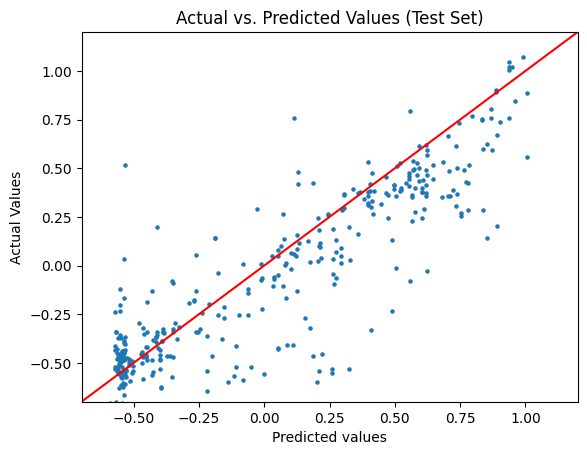

In [20]:
plot_actual_vs_predicted(y_test, y_predicted_test, 'Actual vs. Predicted Values (Test Set)')

In [21]:
# plot_actual_vs_predicted(y_train, y_predicted_train, 'Actual vs. Predicted Values (Train Data Set)')

In [22]:
from sklearn.metrics import r2_score
from scipy import stats

def calculate_metrics(actual, predicted):
  mae = np.mean(np.abs(actual - predicted))
  mse = np.mean((actual - predicted)**2)
  rmse = np.sqrt(mse)
  r_squared = r2_score(actual, predicted)
  corr = np.corrcoef(actual, predicted)[0,0]

  print("MAE:", mae)
  print("MSE:", mse)
  print("RMSE:", rmse)
  print("R-squared:", r_squared)
  print("Correlation:", corr)
  # return mae, mse, rmse, r_squared

In [23]:
print('--------Test Set Results---------')
calculate_metrics(y_test, y_predicted_test.reshape(-1))
print('---------------------------------')
# print('------Train Dataset Results-------')
# calculate_metrics(y_train, y_predicted_train.reshape(-1))
# print('---------------------------------')

--------Test Set Results---------
MAE: 0.17031625881963672
MSE: 0.06094398386634275
RMSE: 0.24686835331071244
R-squared: 0.7519733725706241
Correlation: 0.9999999999999999
---------------------------------


In [24]:
data_opt = 'v2'
# y_train, y_predicted_train = load_results(data_opt=data_opt, split = 'train')
# print(np.mean(np.abs(y_train - y_predicted_train.reshape(-1))))

# y_val, y_predicted_val = load_results(data_opt=data_opt, split = 'val')
# print(np.mean(np.abs(y_val - y_predicted_val.reshape(-1))))

y_test, y_predicted_test = load_results(data_opt=data_opt, split = 'test')
print(np.mean(np.abs(y_test - y_predicted_test.reshape(-1))))

Data Option: 8 channels - New Dataset
v2
Set size: 365	


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.0640001753488162


In [25]:
print('--------Test Set Results---------')
calculate_metrics(y_test, y_predicted_test.reshape(-1))
print('---------------------------------')
# print('------Train Dataset Results-------')
# calculate_metrics(y_train, y_predicted_train.reshape(-1))
# print('---------------------------------')

--------Test Set Results---------
MAE: 0.0640001753488162
MSE: 0.009778866176513449
RMSE: 0.09888814982854846
R-squared: 0.9602024835927521
Correlation: 0.9999999999999999
---------------------------------


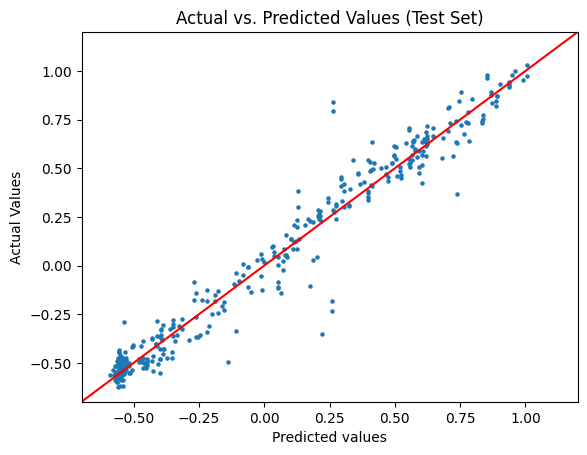

In [26]:
plot_actual_vs_predicted(y_test, y_predicted_test, 'Actual vs. Predicted Values (Test Set)')

In [27]:
# plot_actual_vs_predicted(y_train, y_predicted_train, 'Actual vs. Predicted Values (Train Data Set)')